In [7]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections
import random
from time import time

from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA

import data_handler as dh
import semeval_data_helper as sdh


# plot settings
% matplotlib inline
# print(plt.rcParams.keys())
# plt.rcParams['figure.figsize'] = (16,9)

import mpld3

In [1]:
# reload(sdh)

In [2]:
# reload(nn)
import relembed as nn

In [3]:
# reload(eh)
import experiment_helper as eh

In [4]:
shuffle_seed = 20

In [8]:
# reload(dh)
DH = dh.DataHandler('data/semeval_train_sdp_8000', valid_percent=10, shuffle_seed=shuffle_seed) # for semeval

Creating Data objects...
Done creating Data objects
7999 total examples :: 7199 training : 800 valid (90:10 split)
Vocab size: 22683 Dep size: 50 POS size: 18


In [9]:
# reload(sdh)
train, valid, test, label2int, int2label = sdh.load_semeval_data(include_ends=False, shuffle_seed=shuffle_seed)
num_classes = len(int2label.keys())

Didn't find common ancestor
1790	"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."

(The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport )
Bad sentence: '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
((The imams were removed from a US Airways flight awaiting departure from the Minneapolis - St . Paul airport ., flight , airport ), None)
Skipping this one... '1790\t"The imams were removed from a US Airways <e1>flight</e1> awaiting departure from the Minneapolis-St. Paul <e2>airport</e2>."\r\n'
(None, None, None, 4)
Num training: 7199
Num valididation: 800
Didn't find common ancestor
8310	"Tributes have been paid to the <e1>writer</e1> who created Goodness Gracious Me, the hit BBC television <e2>series</e2>."

(Tributes have been paid to the writer 

In [10]:
print(train['sdps'][:5]) # small sample
print(train['targets'][:5]) # small sample

# convert the semeval data to indices under the wiki vocab:
train['sdps'] = DH.sentences_to_sequences(train['sdps'])
valid['sdps'] = DH.sentences_to_sequences(valid['sdps'])
test['sdps'] = DH.sentences_to_sequences(test['sdps'])
    
train['targets'] = DH.sentences_to_sequences(train['targets'])
valid['targets'] = DH.sentences_to_sequences(valid['targets'])
test['targets'] = DH.sentences_to_sequences(test['targets'])

zip_train = zip(train['raws'], train['sents'], train['sdps'], train['targets'], train['labels'])
zip_valid = zip(valid['raws'], valid['sents'], valid['sdps'], valid['targets'], valid['labels'])
zip_test = zip(test['raws'], test['sents'], test['sdps'], test['targets'])

print(train['sdps'][:5]) # small sample
print(train['targets'][:5]) # small sample

([(u'<X>', u'compound', u'NOUN'), (u'<Y>', u'dobj', u'NOUN')], [(u'<X>', u'nsubj', u'NOUN'), (u'has', u'ROOT', u'VERB'), (u'player', u'dobj', u'NOUN'), (u'<Y>', u'compound', u'NOUN')], [(u'<X>', u'pobj', u'NOUN'), (u'of', u'prep', u'ADP'), (u'<Y>', u'pobj', u'NOUN')], [(u'<X>', u'nsubj', u'NOUN'), (u'is', u'ROOT', u'VERB'), (u'from', u'prep', u'ADP'), (u'<Y>', u'pobj', u'NOUN')], [(u'<X>', u'pobj', u'NOUN'), (u'of', u'prep', u'ADP'), (u'<Y>', u'pobj', u'NOUN')])
((u'country', u'life'), (u'car', u'casette'), (u'jam', u'women'), (u'view', u'bridge'), (u'hill', u'corn'))
[[[22679, 6, 0], [22680, 8, 0]], [[22679, 5, 0], [23, 7, 1], [522, 8, 0], [22680, 6, 0]], [[22679, 1, 0], [2, 2, 3], [22680, 1, 0]], [[22679, 5, 0], [8, 7, 1], [10, 2, 3], [22680, 1, 0]], [[22679, 1, 0], [2, 2, 3], [22680, 1, 0]]]
[[180, 134], [150, 18979], [2494, 305], [769, 911], [2319, 1166]]


In [11]:
max_seq_len = max([len(path) for path in train['sdps']+valid['sdps']+test['sdps']])
print(max_seq_len, DH.max_seq_len)
DH.max_seq_len = max_seq_len

13 13


# Get an idea of the distribution of structures

In [12]:
all_sdps = train['sdps'] + valid['sdps'] + test['sdps']

In [13]:
dep_structures = {}
for sdp in all_sdps:
    dep_structure = tuple([token[1] for token in sdp])
    if dep_structure in dep_structures:
        dep_structures[dep_structure] += 1
    else:
        dep_structures[dep_structure] = 1

In [14]:
len(dep_structures)

/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/thomaseffland/.virtualenvs/rel/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


1461

In [15]:
deps = sorted([s for s in dep_structures.items()], key=lambda x:x[1], reverse=True)

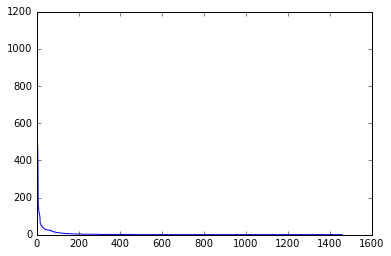

In [16]:
plt.plot(range(len(deps)), [d[1] for d in deps])

(0, 200)

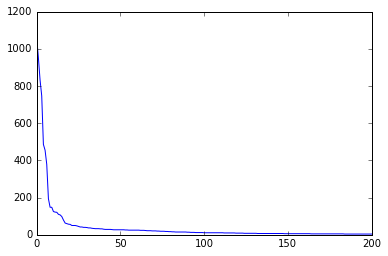

In [17]:
plt.plot(range(len(deps)), [d[1] for d in deps])
plt.xlim([0,200])

# Wow that's a very thin tailed distribution

In [18]:
for i, dep in enumerate(deps[:100]):
    print("%i : count %i : %s" % (i, dep[1], [DH.dep_at(p) for p in dep[0]]))

0 : count 1059 : [u'nsubj', u'ROOT', u'prep', u'pobj']
1 : count 953 : [u'nsubj', u'ROOT', u'dobj']
2 : count 833 : [u'nsubjpass', u'ROOT', u'prep', u'pobj']
3 : count 747 : [u'pobj', u'prep', u'pobj']
4 : count 486 : [u'dobj', u'prep', u'pobj']
5 : count 455 : [u'dobj', u'ROOT', u'prep', u'pobj']
6 : count 379 : [u'nsubj', u'prep', u'pobj']
7 : count 194 : [u'nsubjpass', u'ROOT', u'agent', u'pobj']
8 : count 148 : [u'compound', u'pobj']
9 : count 148 : [u'attr', u'prep', u'pobj']
10 : count 125 : [u'nsubj', u'ROOT', u'dobj', u'prep', u'pobj']
11 : count 122 : [u'compound', u'nsubj']
12 : count 121 : [u'nsubj', u'ROOT', u'attr', u'prep', u'pobj']
13 : count 110 : [u'pobj', u'acl', u'agent', u'pobj']
14 : count 107 : [u'nsubjpass', u'prep', u'pobj']
15 : count 98 : [u'compound', u'dobj']
16 : count 79 : [u'conj', u'prep', u'pobj']
17 : count 63 : [u'nsubj', u'acl', u'agent', u'pobj']
18 : count 60 : [u'nsubj', u'ROOT', u'prep', u'pobj', u'prep', u'pobj']
19 : count 57 : [u'dobj', u'acl'

## Do same for POS structures

In [19]:
pos_structures = {}
for i, sdp in enumerate(all_sdps):
    pos_structure = tuple([token[2] for token in sdp])
    if pos_structure in pos_structures:
        pos_structures[pos_structure] += 1
    else:
        pos_structures[pos_structure] = 1

In [20]:
len(pos_structures)

540

In [21]:
poss = sorted([s for s in pos_structures.items()], key=lambda x:x[1], reverse=True)

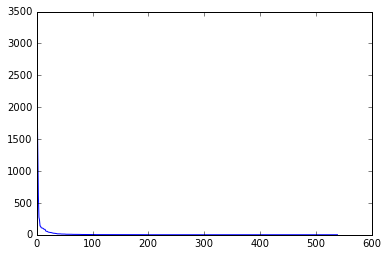

In [22]:
plt.plot(range(len(poss)), [p[1] for p in poss])

(0, 50)

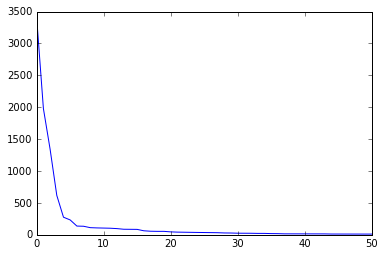

In [23]:
plt.plot(range(len(poss)), [p[1] for p in poss])
plt.xlim([0,50])

In [24]:
for i, pos in enumerate(poss[:100]):
    print("%i : count %i : %s" % (i, pos[1], [DH.pos_at(p) for p in pos[0]]))

0 : count 3398 : [u'NOUN', u'VERB', u'ADP', u'NOUN']
1 : count 1980 : [u'NOUN', u'ADP', u'NOUN']
2 : count 1343 : [u'NOUN', u'VERB', u'NOUN']
3 : count 618 : [u'NOUN', u'NOUN']
4 : count 276 : [u'NOUN', u'VERB', u'NOUN', u'ADP', u'NOUN']
5 : count 233 : [u'NOUN', u'VERB', u'ADP', u'NOUN', u'NOUN']
6 : count 137 : [u'NOUN', u'VERB', u'VERB', u'NOUN']
7 : count 134 : [u'NOUN', u'VERB', u'ADP', u'NOUN', u'ADP', u'NOUN']
8 : count 112 : [u'NOUN', u'NOUN', u'VERB', u'ADP', u'NOUN']
9 : count 108 : [u'NOUN', u'ADP', u'NOUN', u'VERB', u'ADP', u'NOUN']
10 : count 106 : [u'NOUN', u'VERB', u'NOUN', u'NOUN']
11 : count 103 : [u'NOUN', u'VERB', u'ADP', u'NOUN', u'ADJ']
12 : count 97 : [u'NOUN', u'NOUN', u'ADP', u'NOUN']
13 : count 87 : [u'NOUN', u'ADP', u'NOUN', u'ADP', u'NOUN']
14 : count 86 : [u'NOUN', u'ADP', u'NOUN', u'NOUN']
15 : count 85 : [u'NOUN', u'VERB', u'VERB', u'ADP', u'NOUN']
16 : count 63 : [u'NOUN', u'VERB', u'ADV', u'ADP', u'NOUN']
17 : count 56 : [u'NOUN', u'ADP', u'NOUN', u'VERB

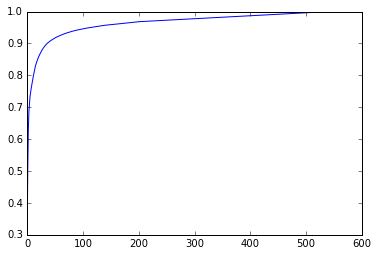

In [25]:
# look at the cdf
plt.plot(range(len(poss)), np.cumsum([p[1] for p in poss])/float(np.sum([p[1] for p in poss])))

(array([  1.00000000e+00,   6.68000000e+02,   3.47000000e+03,
          4.18200000e+03,   1.45300000e+03,   6.08000000e+02,
          2.09000000e+02,   7.30000000e+01,   2.90000000e+01,
          1.30000000e+01,   5.00000000e+00,   3.00000000e+00,
          2.00000000e+00]),
 array([  1.        ,   1.92307692,   2.84615385,   3.76923077,
          4.69230769,   5.61538462,   6.53846154,   7.46153846,
          8.38461538,   9.30769231,  10.23076923,  11.15384615,
         12.07692308,  13.        ]),
 <a list of 13 Patch objects>)

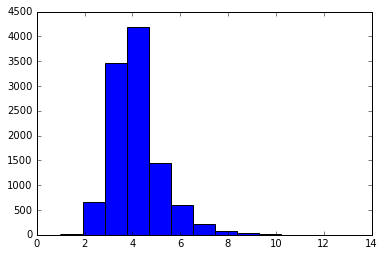

In [27]:
# lets look at them by path length
lengths = [len(p) for p in all_sdps]
plt.hist(lengths, bins=len(set(lengths)))

## So we have less POS structures than DEP structures

For POS structures, we have the top 250 structures covering over 95% of the total mass

So let's use this list of structures as the set of acceptable structures for wikipedia training

Take these top 250 and write them to file, then load them in `ok_sdp` in wiki2sdp

In [28]:
top_structures = [tuple([DH.pos_at(p) for p in pos[0]]) for pos in poss] # as tokens eg, 'NOUN'
# top_structures = [pos[0] for pos in poss[:400]] # as PO vocab indices
with open('sdp_pos_structures.py', 'w') as f:
    f.write('ok_pos_structures = set(%r)' % top_structures[:200])

In [29]:
cat sdp_pos_structures.py

ok_pos_structures = set([(u'NOUN', u'VERB', u'ADP', u'NOUN'), (u'NOUN', u'ADP', u'NOUN'), (u'NOUN', u'VERB', u'NOUN'), (u'NOUN', u'NOUN'), (u'NOUN', u'VERB', u'NOUN', u'ADP', u'NOUN'), (u'NOUN', u'VERB', u'ADP', u'NOUN', u'NOUN'), (u'NOUN', u'VERB', u'VERB', u'NOUN'), (u'NOUN', u'VERB', u'ADP', u'NOUN', u'ADP', u'NOUN'), (u'NOUN', u'NOUN', u'VERB', u'ADP', u'NOUN'), (u'NOUN', u'ADP', u'NOUN', u'VERB', u'ADP', u'NOUN'), (u'NOUN', u'VERB', u'NOUN', u'NOUN'), (u'NOUN', u'VERB', u'ADP', u'NOUN', u'ADJ'), (u'NOUN', u'NOUN', u'ADP', u'NOUN'), (u'NOUN', u'ADP', u'NOUN', u'ADP', u'NOUN'), (u'NOUN', u'ADP', u'NOUN', u'NOUN'), (u'NOUN', u'VERB', u'VERB', u'ADP', u'NOUN'), (u'NOUN', u'VERB', u'ADV', u'ADP', u'NOUN'), (u'NOUN', u'ADP', u'NOUN', u'VERB', u'NOUN'), (u'NOUN', u'NOUN', u'VERB', u'NOUN'), (u'NOUN', u'ADP', u'VERB', u'ADP', u'NOUN'), (u'NOUN', u'VERB', u'ADP', u'VERB', u'NOUN'), (u'NOUN', u'NOUN', u'NOUN'), (u'NOUN', u'VERB', u'ADP', u'ADP', u'NOUN'), (u'NOUN', u'ADJ', u'ADP', u'NOUN'),

In [96]:
[DH.pos_at(a) for a in (0,2,1,0)]

[u'NOUN', u'DET', u'VERB', u'NOUN']